# Milestone 2

Nama: Dwi Putra Satria Utama

Batch 20

Dataset: ChatGPT sentiment analysis (https://www.kaggle.com/datasets/charunisa/chatgpt-sentiment-analysis)

Objective:

Membangun model Sentiment Analysis untuk mengklasifikasikan chatgpt sentimen tweet menjadi positif, netral, atau negatif berdasarkan isi teks/tweet yang diunggah.

Problem Statement:

Dalam proyek ini, tujuan utama adalah untuk mengembangkan sebuah sistem Sentiment Analysis yang dapat mengenali dan mengklasifikasikan sentimen dari teks yang diunggah menjadi tiga kategori: positif, netral, atau negatif. Model yang akan dibangun akan memproses teks yang diberikan dan memberikan hasil prediksi tentang sentimen teks tersebut.

Matriks yang digunakan: Akurasi

# 2 - Import library

In [25]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import string

#pre-processing/feature engineering
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import re
import ast
from nltk.stem import PorterStemmer
from collections import Counter

#modelling
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

#saving
import joblib


# 3 - Data loading

In [26]:
df = pd.read_csv('C:\\\\Users\\\\DELL\\\\OneDrive\\\\HACKTIVE\\\\p2m2 chatgpt sentiment\\\\ChatGPT-sentiment-analysis.csv')

# menampilkan 10 baris pertama
df.head(10)

,Unnamed: 0,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad
5,5,"Just launched ChatGPT, our new AI system which...",good
6,6,"As of 2 minutes ago, @OpenAI released their ne...",bad
7,7,ChatGPT coming out strong refusing to help me ...,good
8,8,#0penAl just deployed a thing I've been helpin...,good
9,9,Research preview of our newest model: ChatGPT\...,neutral


In [27]:
# menampilkan 10 baris terakhir
df.tail(10)

,Unnamed: 0,tweets,labels
219284,219284,Indie Media Today -- 12/31: ChatGPT AI Bias in...,bad
219285,219285,Podcast returns in 2023! 🐈🌙\n.\n#ai #chatgpt #...,bad
219286,219286,There's now an open source alternative to Chat...,good
219287,219287,One of my new favorite thing to do with #ChatG...,good
219288,219288,Sounds like AI can't predict 2023 trends 😆\n#n...,neutral
219289,219289,Other Software Projects Are Now Trying to Repl...,bad
219290,219290,I asked #ChatGPT to write a #NYE Joke for SEOs...,good
219291,219291,chatgpt is being disassembled until it can onl...,bad
219292,219292,2023 predictions by #chatGPT. Nothing really s...,bad
219293,219293,"From ChatGPT, neat stuff https://t.co/qjjUF2Z2m0",neutral


In [28]:
# drop kolom unnamed
df.drop('Unnamed: 0', axis=1, inplace=True)

In [29]:
df.head(5)

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [30]:
# copy data
df_copy=df.copy()

# 4 - EDA

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219294 entries, 0 to 219293
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tweets  219294 non-null  object
 1   labels  219294 non-null  object
dtypes: object(2)
memory usage: 3.3+ MB


Data terdiri dari 219294 baris dan 2 kolom dan tidak terdapat missing values


In [32]:
# menghitung data yang terduplikasi
duplicate = df.duplicated().sum()
duplicate

1671

In [33]:
df.shape

(219294, 2)

Terdapat data yang terduplikasi dan selanjutnya akan dihandling



In [34]:
# handling data duplikat
df = df.drop_duplicates()
df.shape

(217623, 2)

Jumlah: bad        106695
good        55754
neutral     55174
Name: labels, dtype: int64


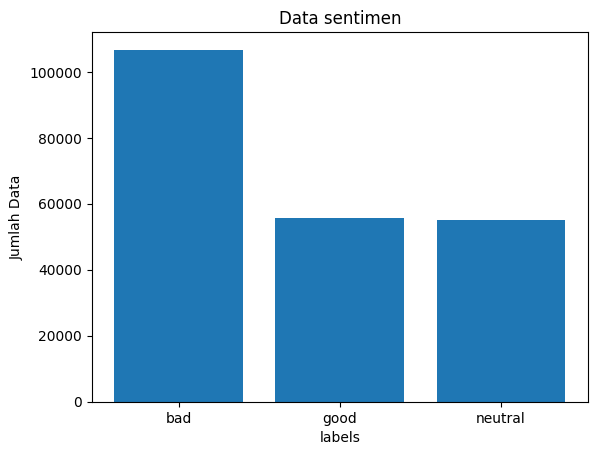

In [35]:
# cek data target

# Hitung jumlah data
sentimen_count = df['labels'].value_counts()
print('Jumlah:', sentimen_count)

# Visualisasi perbandingan jumlah data
plt.bar(sentimen_count.index, sentimen_count.values)
plt.xlabel('labels')
plt.ylabel('Jumlah Data')


# Atur judul dan sumbu y
plt.title('Data sentimen')
plt.ylabel('Jumlah Data')

plt.show()

Data imbalance dimana class bad lebih banyak dari pada yang lainnya

In [36]:
from sklearn.utils import resample

# Memisahkan data berdasarkan kelas
bad_data = df[df['labels'] == 'bad']
good_data = df[df['labels'] == 'good']
neutral_data = df[df['labels'] == 'neutral']

# Melakukan random under-sampling pada setiap kelas
bad_sampled = resample(bad_data, replace=False, n_samples=10000, random_state=42)
good_sampled = resample(good_data, replace=False, n_samples=10000, random_state=42)
neutral_sampled = resample(neutral_data, replace=False, n_samples=10000, random_state=42)

# Menggabungkan hasil under-sampling
df_balanced = pd.concat([bad_sampled, good_sampled, neutral_sampled])

# reset  index 
df_balanced = df_balanced.reset_index(drop=True)

# Cek kembali jumlah data setelah under-sampling
sentimen_count_sampled = df_balanced['labels'].value_counts()
print('Jumlah setelah under-sampling:', sentimen_count_sampled)


Jumlah setelah under-sampling: bad        10000
good       10000
neutral    10000
Name: labels, dtype: int64


Handling dilakukan dengan undersampling karena menurut saya data yang digunakan cukup banyak dan digunakan hanya 10000 data untuk setiap kelas agar tidak terlalu lama dalam proses dikarenakan keterbatasan device.

## WordCloud

In [37]:
df_balanced

,tweets,labels
0,Is #ChatGPT a billionaire in disguise? https:/...,bad
1,I've been using ChatGPT for the last 48 hours....,bad
2,It feels illegal to have access to #ChatGPT f...,bad
3,wtf? how can i use ChatGPT? https://t.co/uGDaB...,bad
4,chatGPT https://t.co/GEWgdAdWUT,bad
...,...,...
29995,ChatGPT is a superior Google.\n\nJesus christ ...,neutral
29996,ChatGPT: The AI-powered Chatbot that is equal ...,neutral
29997,Started using #ChatGPT at my job today and it ...,neutral
29998,ChatGPT on the worth of a human https://t.co/s...,neutral


In [38]:
# Mengambil kolom Review untuk melihat frekuensi kata
text = df_balanced['tweets'].tolist() 

# Menggabungkan list dan lowercase pada semua kata
text = ' '.join(text).lower()

# Mendefinisikan WordCloud
wordcloud = WordCloud(width = 1600, height = 800,
                      background_color ='white',
                      min_font_size = 10).generate(text)

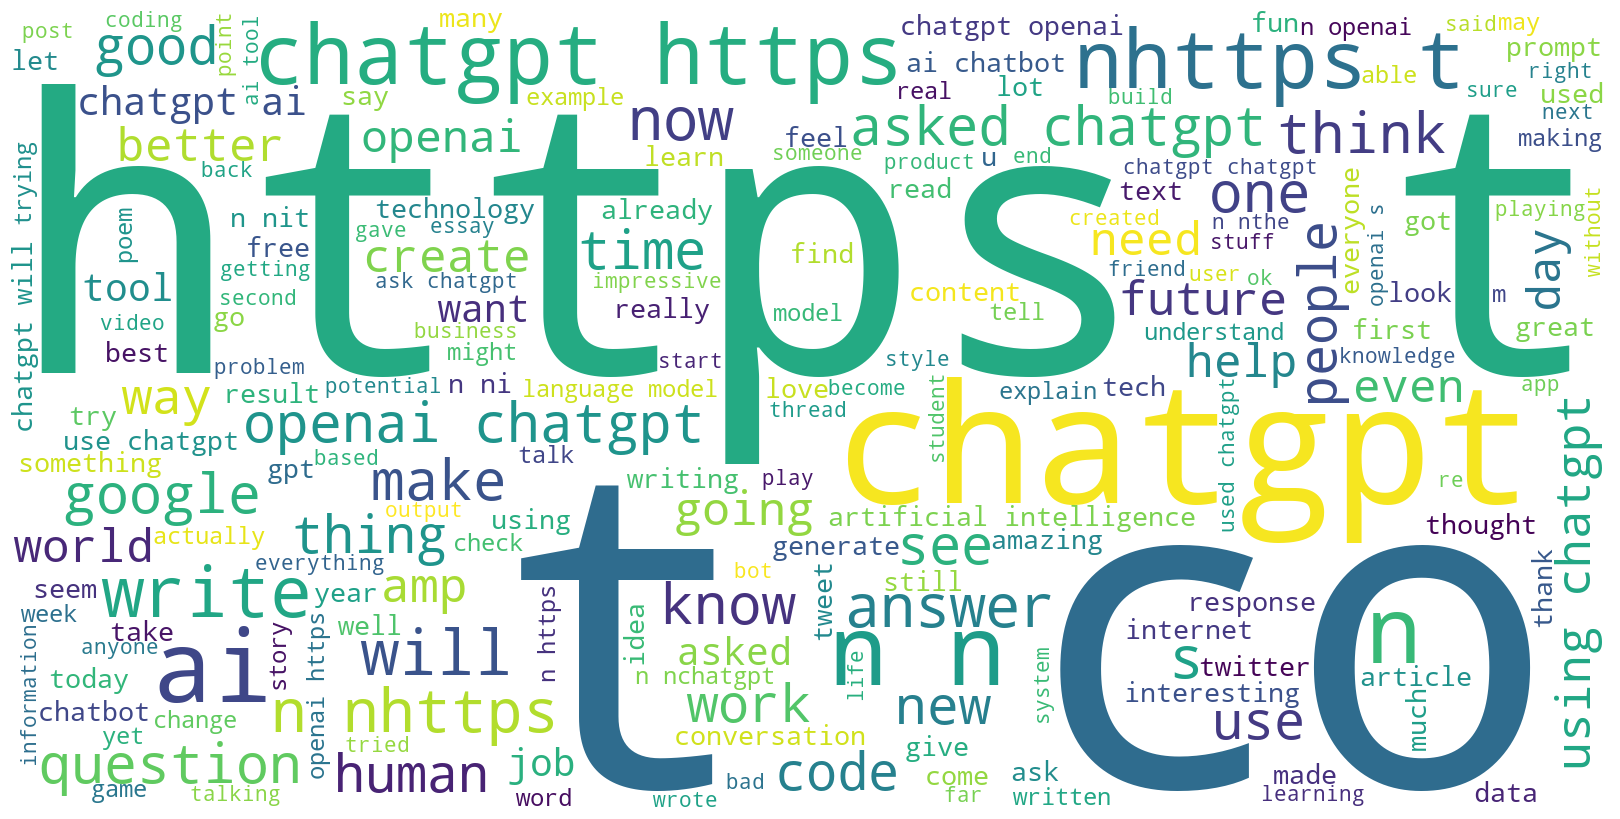

In [39]:
# Plot gambar WordCloud

plt.figure(figsize = (16, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Dalam visualisasi WordCloud (sebelum text prepocessing) di atas, kata-kata yang sering muncul dalam tweets ditampilkan dengan ukuran teks yang lebih besar untuk kata-kata yang memiliki frekuensi kemunculan yang lebih tinggi. Semakin sering sebuah kata muncul dalam tweet, semakin besar ukuran kata tersebut dalam gambar.

Pada gambar tersebut, kata "https" dan "chatgpt" menunjukkan ukuran teks yang paling besar, menandakan bahwa kata-kata ini sangat sering muncul dalam tweets. Namun, kata-kata lainnya mungkin tidak terlihat begitu representatif jika hanya dinilai dari besar atau kecilnya ukuran teks. Hal ini disebabkan karena tidak ada batasan yang jelas mengenai ukuran kata dalam visualisasi WordCloud dan belum dilakukan filtrasi.

# 5 - Text prepocessing

Alasan yang saya lakukan dalam proses ini berdasarkan data yang sudah saya pahami dan dari proses EDA:


1. **Mengganti Kata Singkatan (Replace Slang Words)**:
   - Kode ini membaca file 'chatwords.txt' yang berisi daftar kata singkatan dan penggantinya.
   - Setiap baris dalam file tersebut dipecah menjadi kata-kata.
   - Kata singkatan (slang) dan penggantinya (standard) disimpan dalam kamus `slang_to_standard`.

2. **Fungsi `replace_slang_words`**:
   - Fungsi ini mengambil teks sebagai input dan mencari kata-kata singkatan dalam teks.
   - Jika kata singkatan ditemukan dalam `slang_to_standard`, kata tersebut diganti dengan penggantinya.
   - Fungsi mengembalikan teks yang telah diganti kata singkatannya.

3. **Menggunakan Modul Contractions**:
   - Modul `contractions` digunakan untuk menangani kontraksi dalam teks, seperti mengubah "I'm" menjadi "I am".

4. **Pengolahan Teks Dasar**:
   - Mengubah seluruh teks menjadi huruf kecil (lowercase).
   - Menghapus angka dari teks dengan menggunakan ekspresi reguler `re.sub(r'\d+', '', teks)`.
   - Menghilangkan mention (username Twitter) dengan menggantinya dengan spasi.
   - Menghilangkan hashtag dengan menggantinya dengan spasi.
   - Menghilangkan karakter '\n' dengan menggantinya dengan spasi.
   - Menghilangkan whitespace (spasi ekstra di awal dan akhir teks).
   - Menghilangkan link (URL) dengan menggunakan ekspresi reguler.

5. **Mengganti Singkatan "nt" dengan "not"**:
   - Menggunakan ekspresi reguler untuk mengganti singkatan "nt" menjadi "not" agar konteks negasi tetap terjaga.

6. **Menghapus Tanda Baca**:
   - Menggunakan metode `translate` dengan `str.maketrans` untuk menghapus tanda baca dari teks.

7. **Menghilangkan Karakter Bukan Huruf**:
   - Menggunakan ekspresi reguler `[^A-Za-z\s']` untuk menghilangkan karakter selain huruf, spasi, dan tanda kutip tunggal.

8. **Tokenisasi Kata**:
   - Menggunakan library `nltk` untuk membagi teks menjadi kata-kata (tokenisasi).

9. **Menghapus Stopwords**:
   - Menggunakan daftar stopwords dari library `nltk` untuk menghapus kata-kata umum yang tidak memiliki makna penting.
   - Kata "not" disimpan dalam daftar stopwords agar tidak dihapus karena penting untuk konteks negasi.
   - Beberapa kata tambahan, seperti "chatgpt," "ai," "openai," "ha," "wa," dan "vc," juga ditambahkan ke daftar stopwords untuk dihapus.

10. **Lemmatisasi**:
    - Menggunakan WordNetLemmatizer dari library `nltk` untuk mengubah kata-kata menjadi bentuk dasarnya.
    - Argumen 'v' digunakan untuk mengindikasikan bahwa kita ingin melakukan lemmatisasi untuk kata kerja (verb).

11. **Menggabungkan Kembali Kata-Kata**:
    - Kata-kata yang telah diolah dikembalikan menjadi kalimat yang sudah diolah.



In [40]:
import contractions

# Dictionary untuk penyimpanan penggantian kata singkatan
slang_to_standard = {}

# Membaca dan memproses file chatwords.txt
with open('chatwords.txt', 'r') as file:
    for line in file:
        words = line.strip().split()
        slang = words[0].lower()
        standard = ' '.join(words[1:]).lower()
        slang_to_standard[slang] = standard

# Fungsi untuk mengganti kata singkatan
def replace_slang_words(text):
    words = text.split()
    for i in range(len(words)):
        word = words[i].lower()
        if word in slang_to_standard:
            words[i] = slang_to_standard[word]
    return ' '.join(words)

def text_proses(teks):
    # Mengganti kata singkatan
    teks = replace_slang_words(teks)

    # Menggunakan modul contractions untuk menangani kontraksi
    teks = contractions.fix(teks)
    
    # 1. Mengubah teks menjadi lowercase
    teks = teks.lower()
    
    # 2. Menghapus angka
    teks = re.sub(r'\d+', '', teks)
        
    # Menghilangkan Mention
    teks = re.sub("@[A-Za-z0-9_]+", " ", teks)

    # Menghilangkan Hashtag
    teks = re.sub("#[A-Za-z0-9_]+", " ", teks)
        
    # Menghilangkan \n
    teks = re.sub(r"\\n", " ",teks)
    
    # Menghilangkan Whitespace
    teks = teks.strip()

    # Menghilangkan Link
    teks = re.sub(r"http\S+", " ", teks)
    teks = re.sub(r"www.\S+", " ", teks)
    
    # Mengganti singkatan "nt" dengan "not"
    teks = re.sub(r'\bnt\b', 'not', teks)
    
    # 3. Menghapus tanda baca
    teks = teks.translate(str.maketrans('', '', string.punctuation))
        
    # Menghilangkan yang Bukan Huruf seperti Emoji, Simbol Matematika (seperti μ), dst
    teks = re.sub("[^A-Za-z\s']", " ", teks)
    
    # 4. Tokenisasi kata
    words = word_tokenize(teks)
    
    # 5. Menghapus stopwords, kecuali 'not'
    stop_words = set(stopwords.words('english'))
    stop_words.discard('not')  # Menghapus 'not' dari daftar stopwords
    stop_words.update(['chatgpt', 'ai', 'openai', 'ha', 'wa','vc'])  # Menambah kata-kata ke stopwords
    words = [word for word in words if word not in stop_words]
    
    # 6. Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word, 'v') for word in words]  # Menggunakan 'v' untuk kata kerja
    
    # 7. Menggabungkan kembali kata-kata menjadi kalimat yang sudah diolah
    processed_text = ' '.join(words)
    
    return processed_text

df_balanced['tweets_prosesed'] = df_balanced['tweets'].apply(lambda x: text_proses(x))
df_balanced


,tweets,labels,tweets_prosesed
0,Is #ChatGPT a billionaire in disguise? https:/...,bad,billionaire disguise
1,I've been using ChatGPT for the last 48 hours....,bad,use last hours cross hitherto uncross line hum...
2,It feels illegal to have access to #ChatGPT f...,bad,feel illegal access free
3,wtf? how can i use ChatGPT? https://t.co/uGDaB...,bad,wtf use
4,chatGPT https://t.co/GEWgdAdWUT,bad,
...,...,...,...
29995,ChatGPT is a superior Google.\n\nJesus christ ...,neutral,superior google jesus christ google big trouble
29996,ChatGPT: The AI-powered Chatbot that is equal ...,neutral,aipowered chatbot equal part brilliant terrify
29997,Started using #ChatGPT at my job today and it ...,neutral,start use job today quite helpful
29998,ChatGPT on the worth of a human https://t.co/s...,neutral,worth human


In [41]:
df_word = df_balanced.copy()

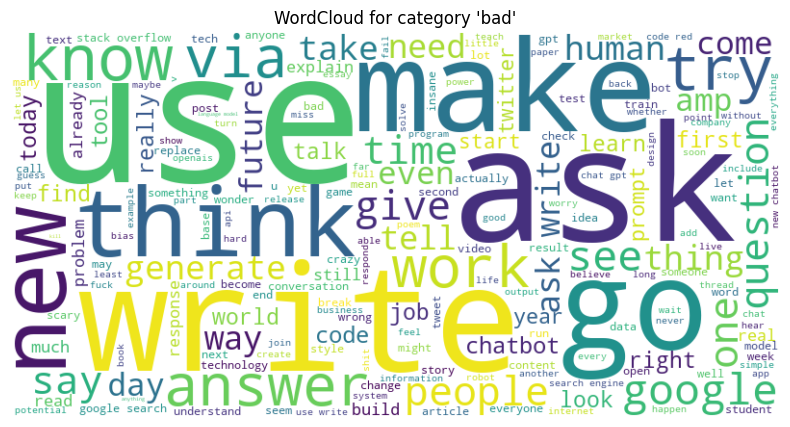

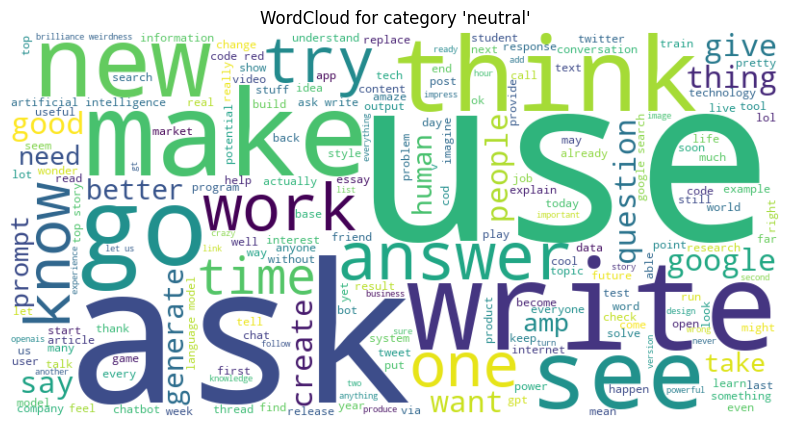

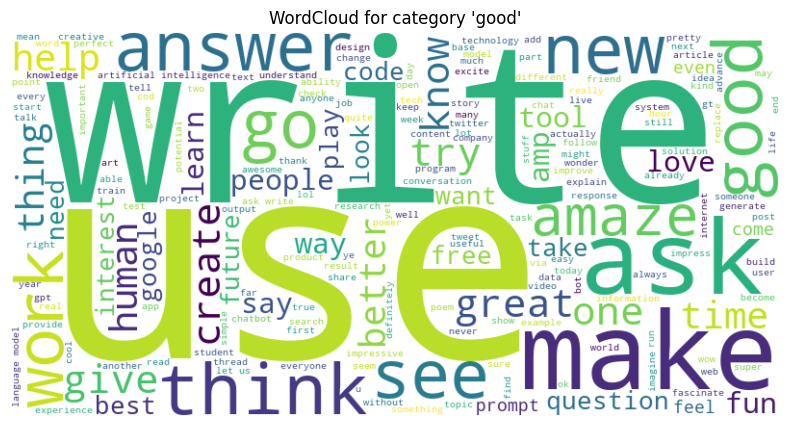

In [42]:
# Function to generate WordCloud
def generate_wordcloud(text, category):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"WordCloud for category '{category}'")
    plt.axis('off')
    plt.show()

# Get data for each category
bad_tweets = df_word[df_word['labels'] == 'bad']['tweets_prosesed'].tolist()
neutral_tweets = df_word[df_word['labels'] == 'neutral']['tweets_prosesed'].tolist()
good_tweets = df_word[df_word['labels'] == 'good']['tweets_prosesed'].tolist()

# Combine text for each category
bad_text = ' '.join(bad_tweets)
neutral_text = ' '.join(neutral_tweets)
good_text = ' '.join(good_tweets)

# Generate WordCloud for each category
generate_wordcloud(bad_text, "bad")
generate_wordcloud(neutral_text, "neutral")
generate_wordcloud(good_text, "good")

Setelah dilakukan text prepocessing bahwa kata pada masing masing kategori masih belum tergambar jelas dengan menghilangkan kata kata yang bias pada setiap kategori, sehingga perlu dilakukan tahapan prepocessing lebih lanjut agar tergambar dengan jelas untuk masing masing kategori

In [43]:
# Setelah fungsi text_proses
df_word['tweets_prosesed'] = df_word['tweets_prosesed'].str.replace(r'\b(?:human|amp|thing|google|need|one|would|could|people|say|give|generate|take|work|try|code|know|good|get|like|say|time|see|question|write|answer|create|think|go|new|make|write|use|ask|)\b', '', regex=True)


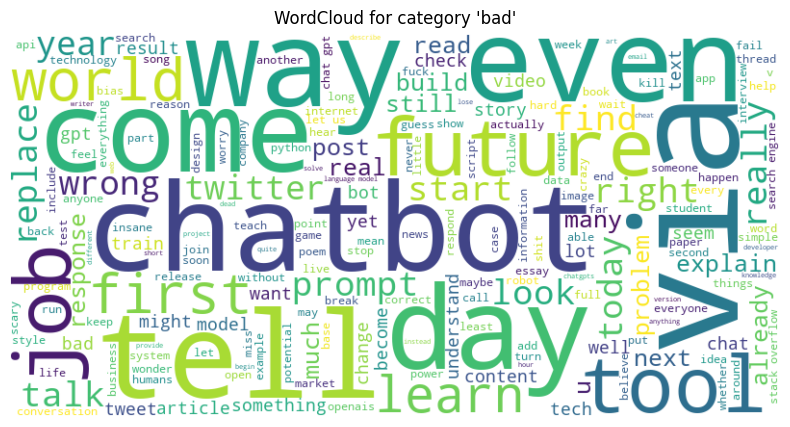

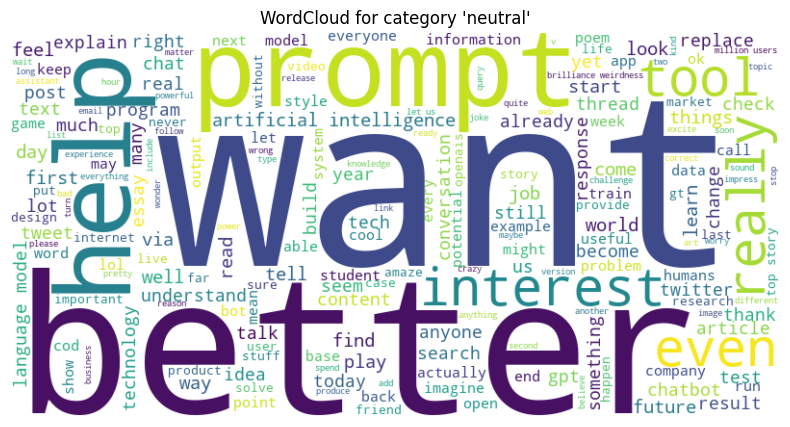

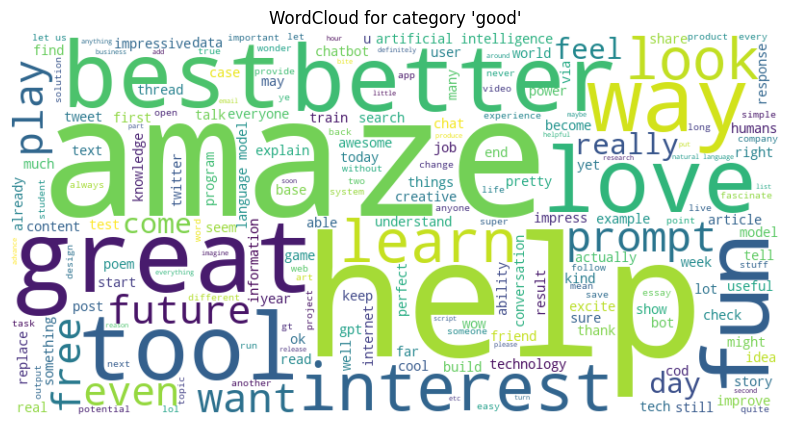

In [44]:
# Function to generate WordCloud
def generate_wordcloud(text, category):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"WordCloud for category '{category}'")
    plt.axis('off')
    plt.show()

# Get data for each category
bad_tweets = df_word[df_word['labels'] == 'bad']['tweets_prosesed'].tolist()
neutral_tweets = df_word[df_word['labels'] == 'neutral']['tweets_prosesed'].tolist()
good_tweets = df_word[df_word['labels'] == 'good']['tweets_prosesed'].tolist()

# Combine text for each category
bad_text = ' '.join(bad_tweets)
neutral_text = ' '.join(neutral_tweets)
good_text = ' '.join(good_tweets)

# Generate WordCloud for each category
generate_wordcloud(bad_text, "bad")
generate_wordcloud(neutral_text, "neutral")
generate_wordcloud(good_text, "good")

Setelah dilakukan text prepocessing lebih lanjut bahwa kata pada kategori bad didominasi oleh chatbot, tell, dan replace. Pada kategori netral didominasi oleh better, want, interest. Sedangkan pada kategori good didominasi oleh amaze, great, dan help.

In [45]:
# Mengubah target dari string ke numeric
label_encoder = LabelEncoder()
df_balanced['class'] = label_encoder.fit_transform(df_balanced['labels'])
df_balanced

,tweets,labels,tweets_prosesed,class
0,Is #ChatGPT a billionaire in disguise? https:/...,bad,billionaire disguise,0
1,I've been using ChatGPT for the last 48 hours....,bad,use last hours cross hitherto uncross line hum...,0
2,It feels illegal to have access to #ChatGPT f...,bad,feel illegal access free,0
3,wtf? how can i use ChatGPT? https://t.co/uGDaB...,bad,wtf use,0
4,chatGPT https://t.co/GEWgdAdWUT,bad,,0
...,...,...,...,...
29995,ChatGPT is a superior Google.\n\nJesus christ ...,neutral,superior google jesus christ google big trouble,2
29996,ChatGPT: The AI-powered Chatbot that is equal ...,neutral,aipowered chatbot equal part brilliant terrify,2
29997,Started using #ChatGPT at my job today and it ...,neutral,start use job today quite helpful,2
29998,ChatGPT on the worth of a human https://t.co/s...,neutral,worth human,2


In [46]:
# Get Label Name
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

{'bad': 0, 'good': 1, 'neutral': 2}


In [47]:
# Split antara X dan y

X = df_balanced['tweets_prosesed'].to_numpy() # features
y = df_balanced['class'].to_numpy() # target


In [48]:
# Split between Train-Set, Val-Set, and Test-Set

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=10)

print('Train Size : ', X_train.shape)
print('Val Size : ', X_val.shape)
print('Test Size : ', X_test.shape)

Train Size :  (19200,)
Val Size :  (4800,)
Test Size :  (6000,)


In [49]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_val_vec = Vectorize.transform(X_val)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<19200x17981 sparse matrix of type '<class 'numpy.int64'>'
	with 195894 stored elements in Compressed Sparse Row format>

In [50]:
# Mencari Jumlah Vocab dan Panjang Token dalam Satu Document

jml_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print("Jumlah vocab : ", jml_vocab)
print("Panjang maksimum kalimat : ", max_sen_len, "kata")

Jumlah vocab :  17981
Panjang maksimum kalimat :  39 kata


In [51]:
# Mengubah Target ke dalam One Hot Encoding
y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [52]:
# Tensorflow pipeline
train_pipe = tf.data.Dataset.from_tensor_slices((X_train, y_train_ohe)).batch(20)
val_pipe = tf.data.Dataset.from_tensor_slices((X_val, y_val_ohe)).batch(20)

In [53]:

text_vectorization = TextVectorization(max_tokens=jml_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)
                                       )

text_vectorization.adapt(X_train)

In [54]:
# Embedding Layer

embedding_baseline = Embedding(input_dim=jml_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len
                      )

In [55]:
text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'not',
 'use',
 'write',
 'ask',
 'like',
 'get',
 'make',
 'new',
 'go',
 'google',
 'answer',
 'think',
 'good',
 'know',
 'try',
 'see',
 'question',
 'time']

# 8 - Model

In [56]:
# Clear Session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [57]:

model_imp1 = Sequential()

# Layer Text Vectorization
model_imp1.add(text_vectorization)

# Layer Embedding
model_imp1.add(embedding_baseline)

# Hidden Layer 1
model_imp1.add(tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True, kernel_initializer=tf.keras.initializers.HeNormal(seed))))

# Hidden Layer 2
model_imp1.add(tf.keras.layers.Bidirectional(LSTM(64, kernel_initializer=tf.keras.initializers.HeNormal(seed))))

# Layer Output
model_imp1.add(Dense(3, activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(seed)))

# Compile
model_imp1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
model_imp1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 39)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 39, 128)           2301568   
                                                                 
 bidirectional (Bidirectiona  (None, 39, 256)          263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                        

- Berdasarkan device yang saya gunakan bahwa total data 30.000 dalam deep learning. Saya menganggap ini adalah data cukup besar sehingga saya memilih algoritma LSTM.
- Pemilihan matrix akurasi didasarkan karena saya sudah menyeimbangkan masing masing kelas dengan random undersampling sehingga tidak masalah ketika menggunakan matrix akurasi.
- Pemilihan optimizer adam karena mempercepat proses pembelajaran dan konvergensi model.
- Pemilihan tf.keras.layers.Bidirectional dalam arsitektur model bertujuan untuk meningkatkan kemampuan model dalam memahami konteks teks dalam dua arah, yaitu maju (forward) dan mundur (backward).

In [58]:
# Mendefinisikan EarlyStopping
#early_stopping = EarlyStopping(monitor='accuracy', patience=7, restore_best_weights=True)

model_imp1_hist = model_imp1.fit(train_pipe, epochs=10, batch_size=20, validation_data=val_pipe)

Epoch 1/10


960/960 [==============================] - 115s 112ms/step - loss: 0.6807 - accuracy: 0.7047 - val_loss: 0.5262 - val_accuracy: 0.7935
Epoch 2/10
960/960 [==============================] - 103s 108ms/step - loss: 0.3499 - accuracy: 0.8686 - val_loss: 0.5351 - val_accuracy: 0.8031
Epoch 3/10
960/960 [==============================] - 101s 105ms/step - loss: 0.1969 - accuracy: 0.9304 - val_loss: 0.5905 - val_accuracy: 0.8135
Epoch 4/10
960/960 [==============================] - 101s 105ms/step - loss: 0.1222 - accuracy: 0.9576 - val_loss: 0.7050 - val_accuracy: 0.8004
Epoch 5/10
960/960 [==============================] - 102s 106ms/step - loss: 0.0812 - accuracy: 0.9730 - val_loss: 0.9462 - val_accuracy: 0.7660
Epoch 6/10
960/960 [==============================] - 99s 103ms/step - loss: 0.0590 - accuracy: 0.9802 - val_loss: 1.0177 - val_accuracy: 0.7852
Epoch 7/10
960/960 [==============================] - 99s 103ms/step - loss: 0.0458 - accuracy: 0.9848 - val_loss: 1.0449 - val_accuracy

In [59]:
# Create DataFrame

history_imp1_df = pd.DataFrame(model_imp1_hist.history)
history_imp1_df

,loss,accuracy,val_loss,val_accuracy
0,0.680740,0.704687,0.526213,0.793542
1,0.349931,0.868594,0.535052,0.803125
2,0.196861,0.930365,0.590520,0.813542
3,0.122223,0.957604,0.705003,0.800417
4,0.081209,0.972969,0.946199,0.766042
5,0.058964,0.980156,1.017676,0.785208
6,0.045843,0.984844,1.044944,0.780417
7,0.034750,0.988750,1.177818,0.780000
8,0.033228,0.989219,1.089330,0.791458
9,0.021635,0.993385,1.227529,0.793542


<Axes: >

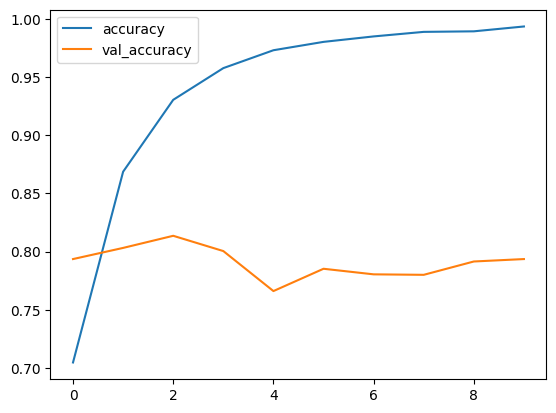

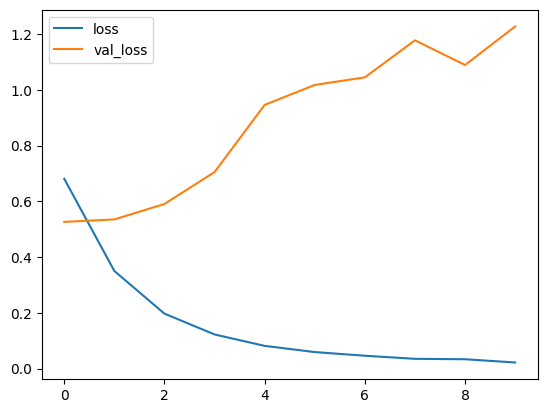

In [60]:
# Plot

history_imp1_df[['accuracy', 'val_accuracy']].plot()
history_imp1_df[['loss', 'val_loss']].plot()

In [61]:
y_pred_improve = model_imp1.predict(X_test)
y_pred_improve = np.argmax(y_pred_improve, axis=1)

print(classification_report(y_test, y_pred_improve))

188/188 [==============================] - 7s 29ms/step
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      2018
           1       0.84      0.77      0.81      1987
           2       0.68      0.78      0.73      1995

    accuracy                           0.79      6000
   macro avg       0.80      0.79      0.79      6000
weighted avg       0.80      0.79      0.79      6000



In [62]:
# Pembuatan DF Act vs Pred
act_pred_imp1 = pd.DataFrame({
            'actual' : y_test,
            'prediction' : np.ndarray.flatten(y_pred_improve)
})
df_act_pred_imp1 = pd.concat([pd.DataFrame(X_test), act_pred_imp1],axis=1)
df_act_pred_imp1 

,0,actual,prediction
0,galactica progress trap wire see,2,2
1,write confront many question draw accord direc...,0,0
2,try digital fashion ask bot describe futuristi...,0,0
3,fusion energy zeroknowledge proof nfts excite ...,2,2
4,knoooww college kid field day,0,0
...,...,...,...
5995,turn convince moral purity introduce policeman...,2,2
5996,thing fuck useless,0,0
5997,clearly go fast friends,1,1
5998,interest small design decisions make way viral...,1,2


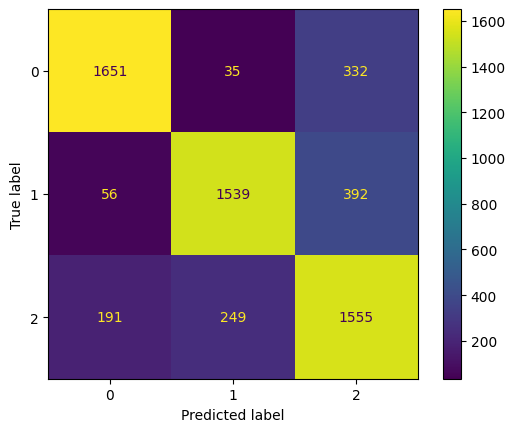

In [63]:
# Confusion Matrix
cm_test_imp1 = confusion_matrix(y_test, y_pred_improve)
ConfusionMatrixDisplay(cm_test_imp1).plot()

# 8 - Improve model


In [64]:
# Clear Session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [65]:

model_baseline = Sequential()

# Layer Text Vectorization
model_baseline.add(text_vectorization)

# Layer Embedding
model_baseline.add(embedding_baseline)

# Hidden Layer 1
model_baseline.add(LSTM(128, return_sequences=True, kernel_initializer=tf.keras.initializers.HeNormal(seed)))

# Hidden Layer 2
model_baseline.add(LSTM(64, kernel_initializer=tf.keras.initializers.HeNormal(seed)))

# Layer Output
model_baseline.add(Dense(3, activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(seed)))

# Compile
model_baseline.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

# Summary
model_baseline.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 39)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 39, 128)           2301568   
                                                                 
 lstm (LSTM)                 (None, 39, 128)           131584    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 2,482,755
Trainable params: 2,482,755
Non-trainable params: 0
______________________________________________

Dalam proses improve model saya mencoba menggunakan basemodel tanpa menggunakan tf.keras.layers.Bidirectional dalam arsitektur model bertujuan untuk mempercepat proses.

In [66]:
# Train the Model
model_baseline_hist = model_baseline.fit(train_pipe, epochs=15, batch_size=20, validation_data=val_pipe)

Epoch 1/15


960/960 [==============================] - 79s 78ms/step - loss: 0.2848 - accuracy: 0.8930 - val_loss: 0.7502 - val_accuracy: 0.7752
Epoch 2/15
960/960 [==============================] - 73s 76ms/step - loss: 0.1090 - accuracy: 0.9664 - val_loss: 0.8743 - val_accuracy: 0.7583
Epoch 3/15
960/960 [==============================] - 73s 76ms/step - loss: 0.0732 - accuracy: 0.9778 - val_loss: 0.9506 - val_accuracy: 0.7521
Epoch 4/15
960/960 [==============================] - 73s 76ms/step - loss: 0.0530 - accuracy: 0.9839 - val_loss: 1.2883 - val_accuracy: 0.7346
Epoch 5/15
960/960 [==============================] - 73s 76ms/step - loss: 0.0452 - accuracy: 0.9862 - val_loss: 1.3234 - val_accuracy: 0.7262
Epoch 6/15
960/960 [==============================] - 76s 80ms/step - loss: 0.0403 - accuracy: 0.9874 - val_loss: 1.3328 - val_accuracy: 0.7292
Epoch 7/15
960/960 [==============================] - 74s 77ms/step - loss: 0.0357 - accuracy: 0.9895 - val_loss: 1.4844 - val_accuracy: 0.7477
Epo

In [67]:
history_baseline_df = pd.DataFrame(model_baseline_hist.history)
history_baseline_df

,loss,accuracy,val_loss,val_accuracy
0,0.284816,0.892969,0.750197,0.775208
1,0.108956,0.966406,0.874319,0.758333
2,0.073196,0.977760,0.950621,0.752083
3,0.053000,0.983854,1.288285,0.734583
4,0.045236,0.986250,1.323407,0.726250
5,0.040268,0.987396,1.332757,0.729167
6,0.035651,0.989531,1.484411,0.747708
7,0.029428,0.991146,1.427374,0.731458
8,0.023481,0.993021,1.577398,0.724167
9,0.021561,0.993750,1.537420,0.743750


<Axes: >

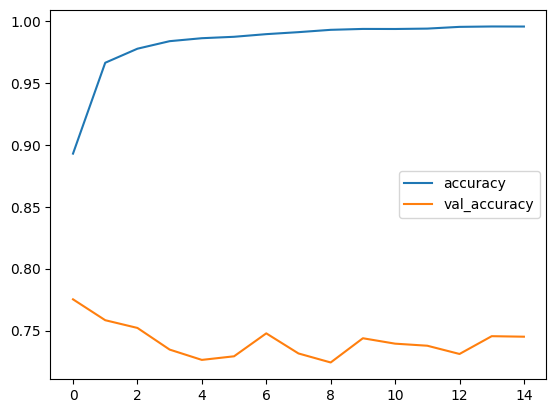

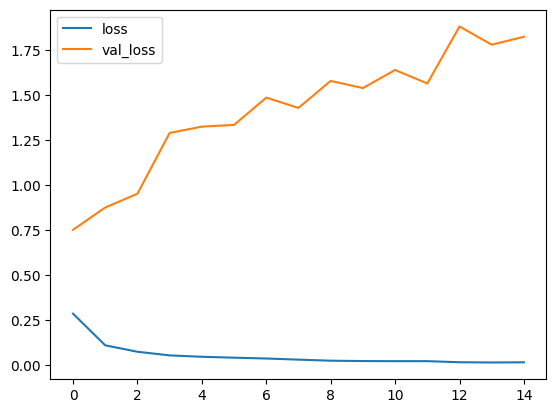

In [68]:
# Plot

history_baseline_df[['accuracy', 'val_accuracy']].plot()
history_baseline_df[['loss', 'val_loss']].plot()

In [69]:
# Model evaluation test set

y_pred_baseline = model_baseline.predict(X_test)
y_pred_baseline = np.argmax(y_pred_baseline, axis=1)

print(classification_report(y_test, y_pred_baseline))

188/188 [==============================] - 5s 22ms/step
              precision    recall  f1-score   support

           0       0.89      0.77      0.82      2018
           1       0.75      0.76      0.75      1987
           2       0.63      0.70      0.66      1995

    accuracy                           0.74      6000
   macro avg       0.75      0.74      0.75      6000
weighted avg       0.75      0.74      0.75      6000



In [70]:
# Pembuatan DF Act vs Pred
act_pred_baseline = pd.DataFrame({
            'actual' : y_test,
            'prediction' : np.ndarray.flatten(y_pred_baseline)
})
df_act_pred_baseline = pd.concat([pd.DataFrame(X_test), act_pred_baseline],axis=1)
df_act_pred_baseline 

,0,actual,prediction
0,galactica progress trap wire see,2,2
1,write confront many question draw accord direc...,0,0
2,try digital fashion ask bot describe futuristi...,0,0
3,fusion energy zeroknowledge proof nfts excite ...,2,1
4,knoooww college kid field day,0,0
...,...,...,...
5995,turn convince moral purity introduce policeman...,2,2
5996,thing fuck useless,0,0
5997,clearly go fast friends,1,1
5998,interest small design decisions make way viral...,1,1


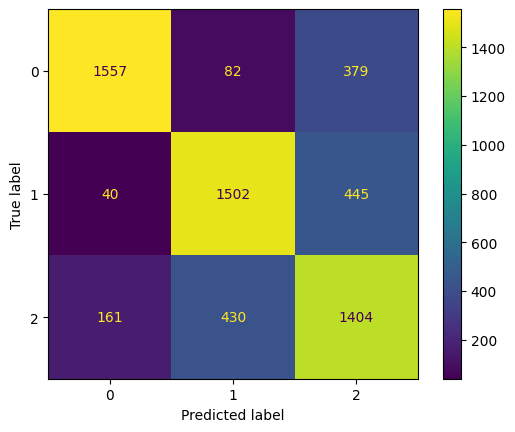

In [71]:
# Confusion Matrix
cm_test_baseline = confusion_matrix(y_test, y_pred_baseline)
ConfusionMatrixDisplay(cm_test_baseline).plot()

- Sebelum Improve:

    Waktu train diatas 80 detik



- Setelah Improve:

    Waktu train dibawah 80 detik
    

Dari hasil di atas, terlihat bahwa model yang telah diimprovisasi (setelah improve) memiliki durasi train yang lebih cepat dibandingkan dengan model yang belum di improve tetapi berpengaruh perubahan pada akurasi hasil test set yang mengalamai penurunan. Sehingga saya memutuskan untuk menggunakan model yang belum diimprove untuk disave.



# Cek kesalahan prediksi


In [78]:
df_diff = df_act_pred_baseline[df_act_pred_baseline['actual'] != df_act_pred_baseline['prediction']]
df_diff.head()


,0,actual,prediction
3,fusion energy zeroknowledge proof nfts excite ...,2,1
6,could prevent users click google link ads gene...,2,0
15,write code like visual interfaces textbased ca...,0,2
25,hope able disrupt googl moat analysis would in...,2,1
33,want emerac internet,0,2


In [73]:
# Memisahkan kelas
class_0 = df_act_pred_baseline[df_act_pred_baseline['actual'] == 0]
class_1 = df_act_pred_baseline[df_act_pred_baseline['actual'] == 1]
class_2 = df_act_pred_baseline[df_act_pred_baseline['actual'] == 2]

# Menghitung frekuensi kata
def get_word_counts(df_act_pred_baseline):
    word_counts = Counter()
    for index, row in df_act_pred_baseline.iterrows():
        words = row.drop(['actual', 'prediction']).str.split()
        word_counts.update(words[0])
    return word_counts

# filter top kata untuk suatu kelas (FP atau FN)
def top_k_words(df_act_pred_baseline, k, target_col):
    df_act_pred_baseline = df_act_pred_baseline[df_act_pred_baseline['prediction'] == target_col]
    word_counts = get_word_counts(df_act_pred_baseline)
    top_k_words = [word for word, _ in word_counts.most_common(k)]
    return top_k_words

# Kelas 0 False Positif 
class_0_fp = top_k_words(class_0, 10, 1)

# Kelas 0 False Negatif 
class_0_fn = top_k_words(class_0, 10, 1) + top_k_words(class_0, 10, 2)

# Kelas 1 False Positif 
class_1_fp = top_k_words(class_1, 10, 0)

# Kelas 1 False Negatif 
class_1_fn = top_k_words(class_1, 10, 0) + top_k_words(class_1, 10, 2)

# Kelas 2 False Positif 
class_2_fp = top_k_words(class_2, 10, 0)

# Kelas 2 False Negatif 
class_2_fn = top_k_words(class_2, 10, 0) + top_k_words(class_2, 10, 1)

# Mencetak hasil
print("False Positif Kelas bad :", class_0_fp)
print("False Negatif Kelas bad :", class_0_fn)
print("False Positif Kelas good :", class_1_fp)
print("False Negatif Kelas good :", class_1_fn)
print("False Positif Kelas neutral :", class_2_fp)
print("False Negatif Kelas neutral :", class_2_fn)


False Positif Kelas bad : ['not', 'write', 'get', 'use', 'like', 'tweet', 'ask', 'google', 'answer', 'yet']
False Negatif Kelas bad : ['not', 'write', 'get', 'use', 'like', 'tweet', 'ask', 'google', 'answer', 'yet', 'not', 'write', 'use', 'ask', 'get', 'give', 'answer', 'code', 'see', 'question']
False Positif Kelas good : ['not', 'use', 'write', 'ask', 'generate', 'code', 'get', 'smart', 'talk', 'tweet']
False Negatif Kelas good : ['not', 'use', 'write', 'ask', 'generate', 'code', 'get', 'smart', 'talk', 'tweet', 'not', 'use', 'write', 'like', 'ask', 'amp', 'get', 'make', 'create', 'go']
False Positif Kelas neutral : ['not', 'use', 'write', 'ask', 'go', 'give', 'google', 'make', 'want', 'like']
False Negatif Kelas neutral : ['not', 'use', 'write', 'ask', 'go', 'give', 'google', 'make', 'want', 'like', 'not', 'use', 'like', 'write', 'ask', 'know', 'make', 'time', 'get', 'question']


In [74]:
# filter top kata untuk suatu kelas (TP atau TN)
def top_k_words_tp_tn(df_act_pred_baseline, k, target_col):
    df_act_pred_baseline = df_act_pred_baseline[df_act_pred_baseline['prediction'] == df_act_pred_baseline['actual']]
    df_act_pred_baseline = df_act_pred_baseline[df_act_pred_baseline['actual'] == target_col]
    word_counts = get_word_counts(df_act_pred_baseline)
    top_k_words = [word for word, _ in word_counts.most_common(k)]
    return top_k_words

# Kelas 0 True Positif 
class_0_tp = top_k_words_tp_tn(class_0, 10, 0)

# Kelas 0 True Negatif 
class_0_tn = top_k_words_tp_tn(df_act_pred_baseline[(df_act_pred_baseline['actual'] != 0)], 10, 0)

# Kelas 1 True Positif 
class_1_tp = top_k_words_tp_tn(class_1, 10, 1)

# Kelas 1 True Negatif 
class_1_tn = top_k_words_tp_tn(df_act_pred_baseline[(df_act_pred_baseline['actual'] != 1)], 10, 1)

# Kelas 2 True Positif 
class_2_tp = top_k_words_tp_tn(class_2, 10, 2)

# Kelas 2 True Negatif 
class_2_tn = top_k_words_tp_tn(df_act_pred_baseline[(df_act_pred_baseline['actual'] != 2)], 10, 2)

# Mencetak hasil
print("True Positif Kelas bad :", class_0_tp)
print("True Negatif Kelas bad :", class_0_tn)
print("True Positif Kelas good :", class_1_tp)
print("True Negatif Kelas good :", class_1_tn)
print("True Positif Kelas neutral :", class_2_tp)
print("True Negatif Kelas neutral :", class_2_tn)


True Positif Kelas bad : ['not', 'write', 'use', 'ask', 'get', 'google', 'new', 'go', 'via', 'make']
True Negatif Kelas bad : []
True Positif Kelas good : ['not', 'like', 'use', 'write', 'ask', 'get', 'good', 'make', 'new', 'see']
True Negatif Kelas good : []
True Positif Kelas neutral : ['not', 'write', 'use', 'like', 'ask', 'get', 'think', 'see', 'new', 'go']
True Negatif Kelas neutral : []


# 9 - Saving

In [75]:
# Save the model with save_format='tf'
model_imp1.save('best_model', save_format='tf')

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


In [76]:
# Save Model
model_imp1.save('best_model1')

INFO:tensorflow:Assets written to: best_model1\assets


INFO:tensorflow:Assets written to: best_model1\assets


# 10 - Kesimpulan

`Berdasarkan proses dan analisis yang telah dilakukan pada data di atas, berikut adalah kesimpulan secara keseluruhan:`

- Ukuran Data: Data terdiri dari 219.294 baris dan 2 kolom. Data ini tidak memiliki missing values.

- Handling Data Terduplikasi: Data yang terduplikasi telah dihapus untuk menghindari pengaruh data yang berlebihan pada model.

- Handling Data Imbalance: Data imbalance telah diatasi dengan menggunakan teknik random undersampling untuk setiap kelas sehingga setiap kelas memiliki 10.000 data.

- Visualisasi WordCloud: WordCloud digunakan untuk memvisualisasikan kata-kata yang sering muncul dalam teks tweet sebelum dilakukan text preprocessing. Kata-kata yang sering muncul ditampilkan dengan ukuran teks yang lebih besar.

- Text Preprocessing: Teks tweet telah di preprocessing dengan mengubah teks menjadi lowercase, menghilangkan mention, hashtag, link, karakter khusus, dan kata "RT". Selain itu, dilakukan tokenisasi dan lemmatisasi untuk mengubah kata-kata menjadi bentuk dasar.

- Model Selection: Berdasarkan karakteristik data yang besar dan kompleks, serta tujuan analisis sentimen, digunakan model LSTM untuk meningkatkan kemampuan model dalam memahami konteks teks.

- Model Evaluation: Model dievaluasi menggunakan metrik akurasi karena data telah di seimbangkan melalui random undersampling sehingga akurasi dapat memberikan gambaran yang baik tentang performa model.

- Overfitting: Terdapat masalah overfitting pada model, yaitu model memiliki akurasi yang tinggi pada data latih (train accuracy) tetapi performa menurun pada data uji (test accuracy). Hal ini menunjukkan model memiliki kemampuan untuk mengingat data latih dengan baik tetapi tidak mampu melakukan generalisasi dengan baik pada data test.

- Improvement Model: Dilakukan percobaan untuk memperbaiki masalah overfitting dengan mengubah arsitektur model, namun tetap menghadapi masalah overfitting meskipun durasi train lebih cepat.

- Kesimpulan: Dengan mempertimbangkan kondisi train dan hasil akurasi pada data uji, model ini dapat digolongkan sebagai "overfitting". Terdapat perbedaan yang cukup besar antara train accuracy dan test accuracy, yang menunjukkan bahwa model tidak mampu melakukan generalisasi dengan baik pada data uji.

`Rekomendasi untuk perbaikan selanjutnya adalah:`

- Melakukan penyesuaian arsitektur model untuk mengurangi overfitting, seperti menggunakan teknik  dropout
- Memperluas kamus stop_words untuk menghapus lebih banyak kata-kata yang tidak relevan dalam analisis sentimen.


`Kelebihan:`

- High Train Accuracy: Hasil train accuracy yang tinggi (0.9) menunjukkan bahwa model memiliki kemampuan untuk "menghafal" data latih dengan baik dan dapat mengklasifikasikan data latih dengan akurat.



`Kekurangan:`

- Penurunan Test Accuracy setelah Improvement: Meskipun telah dilakukan perbaikan (improve model) dengan menghapus lapisan Bidirectional, test accuracy mengalami penurunan , yang menandakan bahwa model ini masih mengalami masalah overfitting.

- Overfitting: Perbedaan yang signifikan antara train accuracy dan test accuracy menunjukkan adanya masalah overfitting. Model "terlalu menghafal" data latih dan tidak dapat secara efektif menangkap pola yang relevan pada data uji.

- Ketidakakuratan Prediksi: Model yang overfitting cenderung memberikan prediksi yang tidak akurat pada data baru atau data uji. Hal ini dapat menyebabkan keputusan bisnis yang salah, misalnya prediksi sentimen yang tidak tepat pada produk atau layanan tertentu.

- Kehilangan Kesempatan: Overfitting dapat menyebabkan kehilangan kesempatan bisnis. Jika model tidak dapat mengenali pola yang relevan dalam data uji, maka kesempatan untuk mengambil keputusan bisnis yang lebih tepat dan optimal dapat terlewatkan.

- Efisiensi Rendah: Model yang kompleks akibat overfitting dapat memerlukan lebih banyak sumber daya komputasi dan waktu untuk pelatihan dan prediksi. Hal ini dapat menghambat efisiensi dan kinerja proses bisnis.

`Implementasi pada bisnis:`
- Feedback Pelanggan yang Lebih Cepat dan Akurat: Implementasi model sentimen analisis dalam bisnis memungkinkan perusahaan untuk secara cepat dan akurat menganalisis feedback pelanggan dari berbagai sumber seperti ulasan produk, media sosial, atau survei. Hal ini membantu dalam memahami perasaan dan preferensi pelanggan dengan lebih baik, sehingga perusahaan dapat merespons secara tepat waktu dan melakukan perbaikan atau penyesuaian produk dan layanan sesuai kebutuhan pelanggan.

- Pengambilan Keputusan Berdasarkan Data: Model sentimen analisis membantu perusahaan dalam mengambil keputusan berdasarkan data dan bukti nyata dari sentimen pelanggan. Dengan analisis data yang akurat, perusahaan dapat mengidentifikasi pola dan tren yang relevan untuk menginformasikan keputusan bisnis strategis, seperti pengembangan produk baru, peningkatan layanan pelanggan, atau perbaikan proses operasional.

- Meningkatkan Kepuasan Pelanggan dan Loyalitas: Dengan memahami sentimen pelanggan, perusahaan dapat meningkatkan kualitas produk dan layanan sesuai dengan harapan pelanggan. Ini berdampak positif pada kepuasan pelanggan dan meningkatkan loyalitas pelanggan. Pelanggan yang puas cenderung menjadi pelanggan yang loyal dan berpotensi menjadi pembawa pesan positif tentang merek atau perusahaan, yang berkontribusi pada pertumbuhan dan kesuksesan jangka panjang bisnis.